<a href="https://colab.research.google.com/github/rafaelnordavind/artigo-final/blob/main/04_Artigo_keras_10min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LSTM
from keras.models import load_model
import keras

<ipython-input-1-a24c07ddc17f>:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
# Baixando a base de dados do repositório do github
!mkdir dataset
!wget --no-check-certificate \
"https://raw.githubusercontent.com/rafaelnordavind/artigo-final/main/dataset/df_max_requests_10min.csv" \
-O "dataset/df_max_requests_10min.csv"

mkdir: cannot create directory ‘dataset’: File exists
--2023-06-26 07:29:32--  https://raw.githubusercontent.com/rafaelnordavind/artigo-final/main/dataset/df_max_requests_10min.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62099 (61K) [text/plain]
Saving to: ‘dataset/df_max_requests_10min.csv’

dataset/df_max_requ 100%[===================>]  60.64K  --.-KB/s    in 0.01s   

2023-06-26 07:29:33 (4.46 MB/s) - ‘dataset/df_max_requests_10min.csv’ saved [62099/62099]



In [3]:
data_df = pd.read_csv('dataset/df_max_requests_10min.csv', parse_dates=['timestamp'])
# Converte a coluna timestamp para o formato datetime
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'], format='%d/%b/%Y:%H:%M:%S %z')
# Setando a coluna timestamp como indice
data_df.set_index('timestamp', inplace=True)
data_df.head()

,num_requests
timestamp,
1995-08-28 00:00:00-04:00,1493
1995-08-28 00:10:00-04:00,1543
1995-08-28 00:20:00-04:00,1265
1995-08-28 00:30:00-04:00,1116
1995-08-28 00:40:00-04:00,1567


In [4]:
data_df.shape

(2016, 1)

In [5]:
data_df.tail()

,num_requests
timestamp,
1995-09-10 23:10:00-04:00,1471
1995-09-10 23:20:00-04:00,1459
1995-09-10 23:30:00-04:00,1551
1995-09-10 23:40:00-04:00,1284
1995-09-10 23:50:00-04:00,1551


In [6]:
#data_df['timestamp'] = pd.to_datetime(data_df['timestamp'])

In [7]:
data_df.head()

,num_requests
timestamp,
1995-08-28 00:00:00-04:00,1493
1995-08-28 00:10:00-04:00,1543
1995-08-28 00:20:00-04:00,1265
1995-08-28 00:30:00-04:00,1116
1995-08-28 00:40:00-04:00,1567


In [8]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(data_df['num_requests'].values.reshape(-1, 1))

In [9]:
dataset[0:10]

array([[0.38390332],
       [0.39676009],
       [0.32527642],
       [0.28696323],
       [0.40293134],
       [0.38416045],
       [0.25867832],
       [0.26639239],
       [0.26870661],
       [0.30856261]])

In [10]:
# split into train and test sets
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1512 504


In [11]:
print(len(data_df))

2016


In [12]:
# convert an array of values into a dataset matrix
window_size = 150
def create_dataset(dataset, look_back=window_size):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
x_train, y_train = create_dataset(train, look_back=window_size)
x_test, y_test = create_dataset(test, look_back=window_size)

In [14]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1361, 150)
(1361,)
(353, 150)
(353,)


In [15]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [16]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1361, 1, 150)
(1361,)
(353, 1, 150)
(353,)


In [17]:
# create and fit the LSTM network
from keras.layers import Bidirectional, Dropout
look_back = window_size
model = Sequential()
model.add(LSTM(64, input_shape=(1, look_back)))
model.add(Dropout(0.2))  # Adiciona camada de dropout com taxa de 0.2
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mae"])
history = model.fit(
            x_train,
            y_train,
            steps_per_epoch = 100,
            epochs = 300,
            validation_steps = 10,
            validation_data=(x_test, y_test),
            verbose = 2,
            batch_size=10
            )
model.summary()


Epoch 1/300
100/100 - 5s - loss: 0.0170 - mae: 0.0949 - val_loss: 0.0085 - val_mae: 0.0671 - 5s/epoch - 53ms/step
Epoch 2/300
100/100 - 1s - loss: 0.0088 - mae: 0.0716 - val_loss: 0.0075 - val_mae: 0.0688 - 624ms/epoch - 6ms/step
Epoch 3/300
100/100 - 1s - loss: 0.0087 - mae: 0.0687 - val_loss: 0.0071 - val_mae: 0.0650 - 582ms/epoch - 6ms/step
Epoch 4/300
100/100 - 1s - loss: 0.0067 - mae: 0.0618 - val_loss: 0.0053 - val_mae: 0.0534 - 607ms/epoch - 6ms/step
Epoch 5/300
100/100 - 1s - loss: 0.0069 - mae: 0.0627 - val_loss: 0.0050 - val_mae: 0.0522 - 532ms/epoch - 5ms/step
Epoch 6/300
100/100 - 1s - loss: 0.0063 - mae: 0.0592 - val_loss: 0.0079 - val_mae: 0.0707 - 535ms/epoch - 5ms/step
Epoch 7/300
100/100 - 0s - loss: 0.0066 - mae: 0.0610 - val_loss: 0.0053 - val_mae: 0.0525 - 463ms/epoch - 5ms/step
Epoch 8/300
100/100 - 1s - loss: 0.0066 - mae: 0.0598 - val_loss: 0.0052 - val_mae: 0.0516 - 549ms/epoch - 5ms/step
Epoch 9/300
100/100 - 1s - loss: 0.0065 - mae: 0.0624 - val_loss: 0.0069 -

In [18]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

12/12 [==============================] - 0s 2ms/step
Train Score: 180.76 RMSE
Test Score: 235.88 RMSE


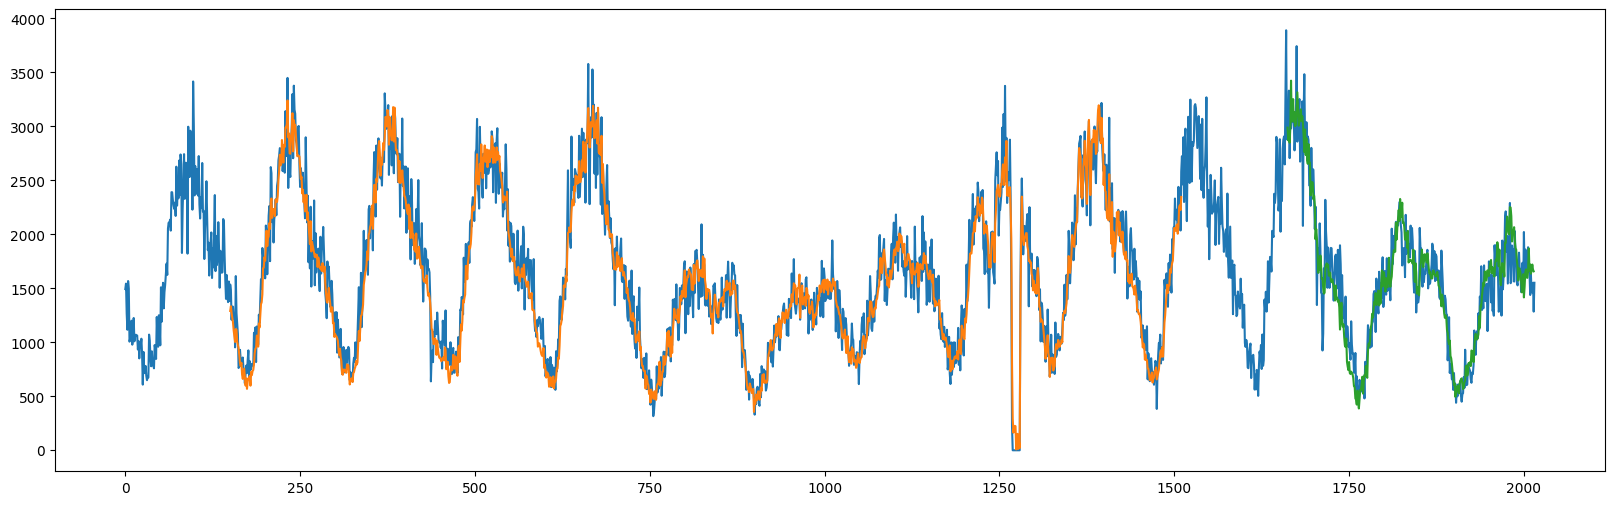

In [19]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,6))
plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

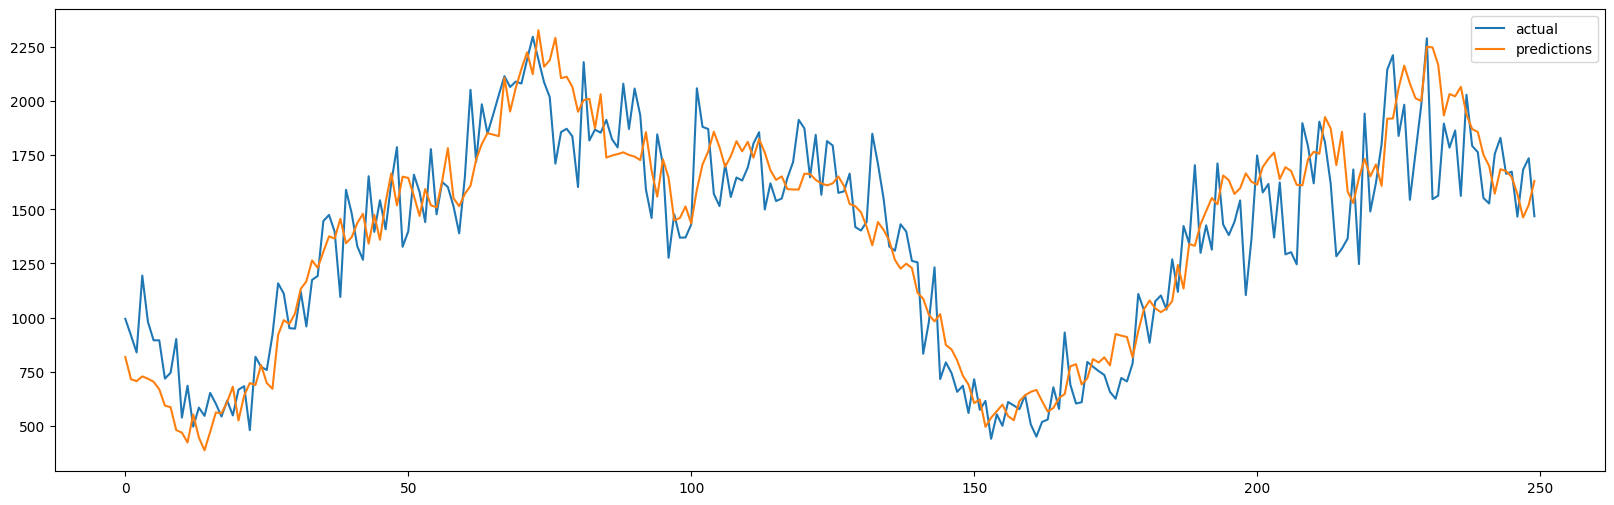

In [20]:
## visualize results
plt.figure(figsize=(20,6))
plt.plot(min_max_scaler.inverse_transform(dataset)[1750:2000], label = 'actual')
plt.plot(testPredictPlot[1750:2000], label = 'predictions')
plt.legend()

>reference: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


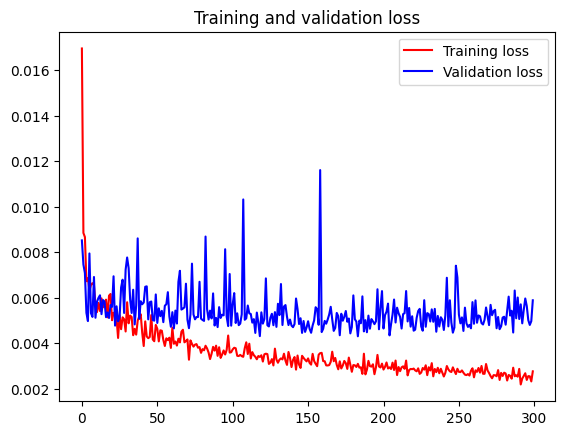

<Figure size 640x480 with 0 Axes>

In [21]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()